In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras import layers
from sklearn import metrics
import keras_tuner
import seaborn as sns
import struct
import time
import pickle
import itertools
np.random.seed(0)

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix. 
    Normalization can be applied by setting normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm. sum (axis=1)[:, np.newaxis] 
        print("Normalized confusion matrix")
    else:    
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product (range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j]> thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [6]:
def build_model(hp):
    model = keras.Sequential()
    model.add(Dense(units=128, input_shape=(784,), activation='relu'))
    model.add(
        layers.Dense(
            # Tune number of units.
            units=hp.Int("units_1", min_value=32, max_value=1024, step=8),
            # Tune the activation function to use.
            activation=hp.Choice("activation_1", ["relu", "tanh"]),
        )
    )
    model.add(
        layers.Dense(
            # Tune number of units.
            units=hp.Int("units_2", min_value=96, max_value=1024, step=8),
            # Tune the activation function to use.
            activation=hp.Choice("activation_2", ["relu", "tanh"]),
        )
    )
    # Tune whether to use dropout.
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(10, activation="softmax"))
    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [7]:
raw_train = read_idx("train-images-idx3-ubyte")
train_data = raw_train / 255.0
train_data = np.reshape(train_data, (60000, 28*28))
train_label = read_idx("train-labels-idx1-ubyte")
raw_test = read_idx("t10k-images-idx3-ubyte")
test_data = raw_test / 255.0
test_data = np.reshape(test_data, (10000, 28*28))
test_label = read_idx("t10k-labels-idx1-ubyte")

In [8]:
num_classes = 10 #number of classes, here is 10 (0,1,...,9)
train_label = keras.utils.to_categorical(train_label, num_classes)
test_label_cat = keras.utils.to_categorical(test_label, num_classes)

In [9]:
build_model(keras_tuner.HyperParameters())

In [10]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=512,
    alpha=0.00001,
    beta=2.9,
    overwrite=True,
    seed=None,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=0,
    max_consecutive_failed_trials=5
)
tuner.search_space_summary()

Search space summary
Default search space size: 6
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 8, 'sampling': 'linear'}
activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 96, 'max_value': 1024, 'step': 8, 'sampling': 'linear'}
activation_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [11]:
tuner.search(train_data, train_label, batch_size=2048, epochs=16, validation_data=(test_data, test_label_cat))

Trial 512 Complete [00h 00m 19s]
val_accuracy: 0.9787999987602234

Best val_accuracy So Far: 0.9822999835014343
Total elapsed time: 02h 31m 27s
INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 105 summary
Hyperparameters:
units_1: 944
activation_1: relu
units_2: 720
activation_2: tanh
dropout: True
lr: 0.0021493596329156947
Score: 0.9822999835014343

Trial 071 summary
Hyperparameters:
units_1: 768
activation_1: relu
units_2: 288
activation_2: tanh
dropout: True
lr: 0.002886731764206911
Score: 0.9821000099182129

Trial 362 summary
Hyperparameters:
units_1: 920
activation_1: relu
units_2: 296
activation_2: tanh
dropout: True
lr: 0.0025602057729449297
Score: 0.9821000099182129

Trial 154 summary
Hyperparameters:
units_1: 928
activation_1: relu
units_2: 296
activation_2: relu
dropout: True
lr: 0.0018034959687495851
Score: 0.9819999933242798

Trial 367 summary
Hyperparameters:
units_1: 568
activation_1: relu
units_2: 376
activation_2: tanh
dropout: True
lr: 0.0036540232333297463
Score: 0.9818999767303467

Trial 200 summary
Hyperparameters:
units_1: 712
activ

In [23]:
# Get the top 5 models.
models = tuner.get_best_models(num_models=5)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build()
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 944)               121776    
                                                                 
 dense_2 (Dense)             (None, 720)               680400    
                                                                 
 dropout (Dropout)           (None, 720)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                7210      
                                                                 
Total params: 909,866
Trainable params: 909,866
Non-trainable params: 0
_________________________________________________________________


In [31]:
pkl_filename = "pickle_nn_hyper_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(best_model, file)

In [ ]:
pkl_filename = "pickle_nn_hyper_model.pkl"
with open(pkl_filename, 'rb') as file:
    best_model = pickle.load(file)

In [25]:
start = time.time()
test_loss, test_acc = best_model.evaluate(test_data, test_label_cat)
print("Test Loss: {}, Test Accuracy: {}".format(test_loss, test_acc))   
end = time.time()
print("NN Predict Time: ", end - start,"s")

313/313 [==============================] - 1s 3ms/step - loss: 0.0766 - accuracy: 0.9823
Test Loss: 0.07659191638231277, Test Accuracy: 0.9822999835014343
NN Predict Time:  1.4948174953460693 s


In [33]:
start = time.time()
x_test = test_data
y_true = test_label
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
end = time.time()
print("NN Predict Time: ", end - start,"s")

313/313 [==============================] - 1s 3ms/step
NN Predict Time:  1.2828521728515625 s


Confusion matrix, without normalization
[[ 971    0    0    0    1    1    2    1    2    2]
 [   0 1128    2    0    0    0    1    1    3    0]
 [   2    0 1016    1    3    0    3    3    3    1]
 [   1    0    4  985    0    5    0    4    6    5]
 [   0    0    4    0  970    0    2    1    0    5]
 [   3    0    0    9    1  872    3    0    3    1]
 [   5    2    1    1    4    3  940    0    2    0]
 [   0    3    8    2    1    0    0 1007    3    4]
 [   5    0    1    3    3    3    1    4  950    4]
 [   3    2    0    2    8    3    0    3    4  984]]


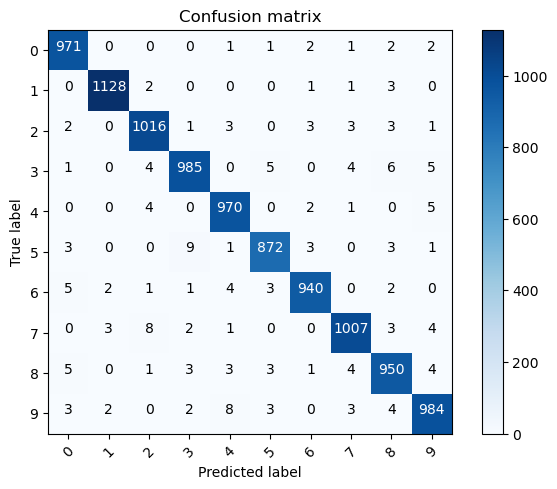

In [34]:
cm = metrics.confusion_matrix(y_true, y_pred_classes)
plot_confusion_matrix(cm, ["0","1","2","3","4","5","6","7","8","9"]) 

In [35]:
errors = (y_pred_classes - y_true != 0)
y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
x_test_errors = x_test[errors]

In [36]:
y_pred_errors_probability = np.max(y_pred_errors, axis=1)
true_probability_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))
diff_errors_pred_true = y_pred_errors_probability - true_probability_errors

# Get list of indices of sorted differences
sorted_idx_diff_errors = np.argsort(diff_errors_pred_true)
top_idx_diff_errors = sorted_idx_diff_errors[-20:] # 5 last ones

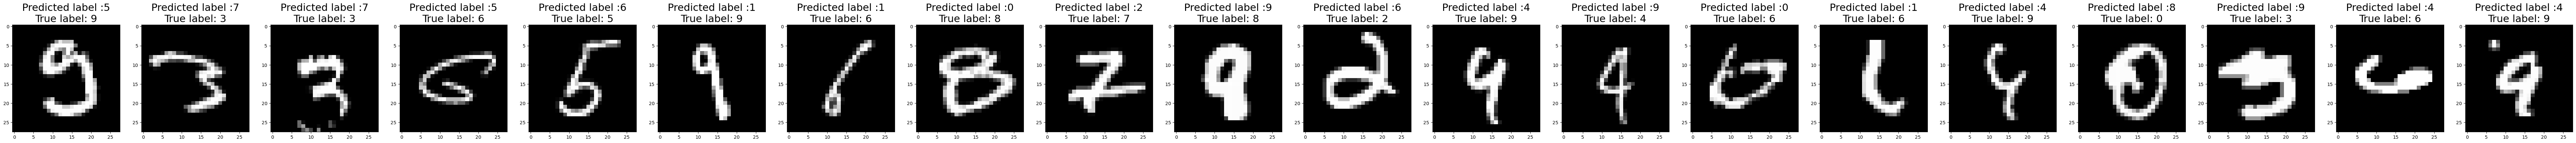

In [37]:
# Show Top Errors
num = len(top_idx_diff_errors)
f, ax = plt.subplots(1, num, figsize=(100,30))

for i in range(0, num):
  idx = top_idx_diff_errors[i]
  sample = x_test_errors[idx].reshape(28,28)
  y_t = y_true_errors[idx]
  y_p = y_pred_classes_errors[idx]
  ax[i].imshow(sample, cmap='gray')
  ax[i].set_title("Predicted label :{}\nTrue label: {}".format(y_p, y_t), fontsize=22)

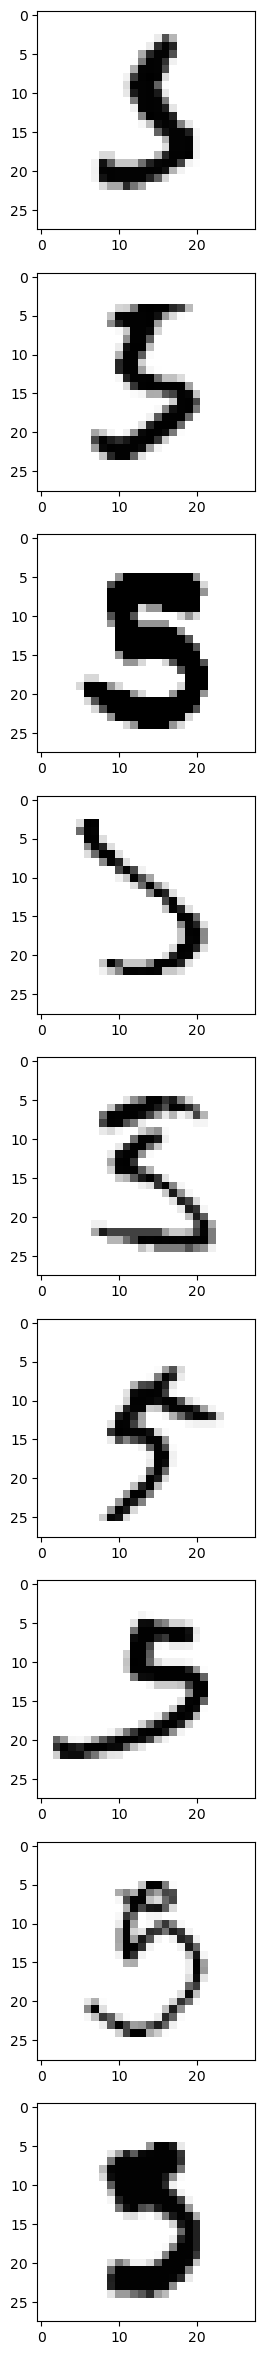

In [38]:
idx = np.where((y_pred_classes == 3) & (y_true == 5))[0]
fig = plt.figure(figsize=(5,30))
for i in range(len(idx)):
    ax = fig.add_subplot(len(idx),1 , i + 1)
    imgplot = ax.imshow(np.reshape(x_test[idx[i],:], (28,28)), cmap=mpl.colormaps['Greys'])
    imgplot.set_interpolation("nearest")
plt.show()

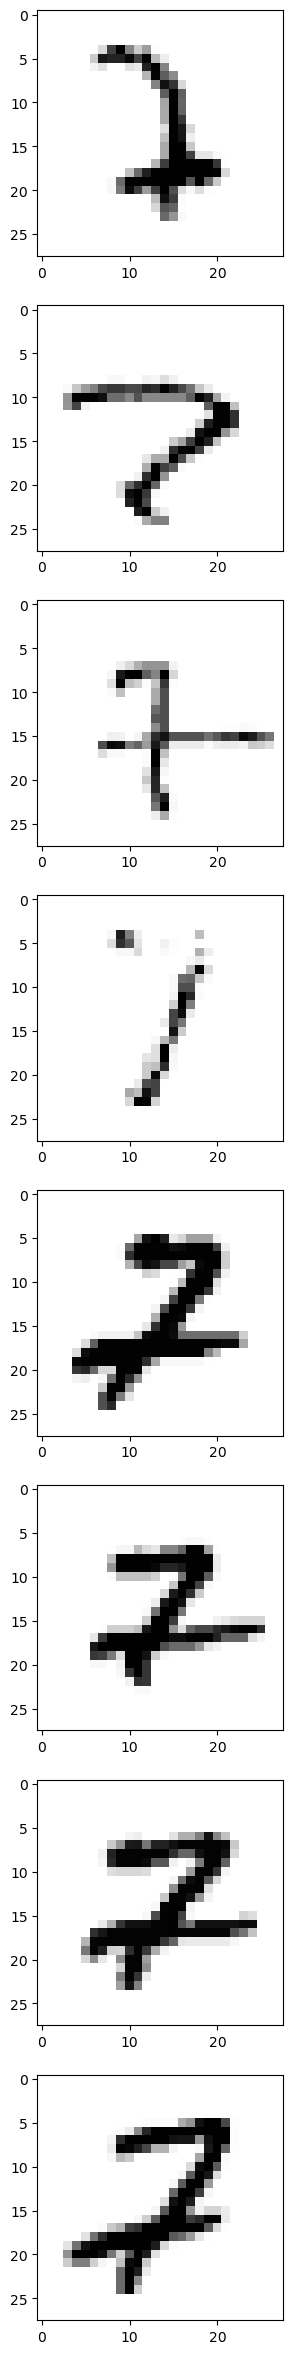

In [39]:
idx = np.where((y_pred_classes == 2) & (y_true == 7))[0]
fig = plt.figure(figsize=(5,30))
for i in range(len(idx)):
    ax = fig.add_subplot(len(idx),1 , i + 1)
    imgplot = ax.imshow(np.reshape(x_test[idx[i],:], (28,28)), cmap=mpl.colormaps['Greys'])
    imgplot.set_interpolation("nearest")
plt.show()

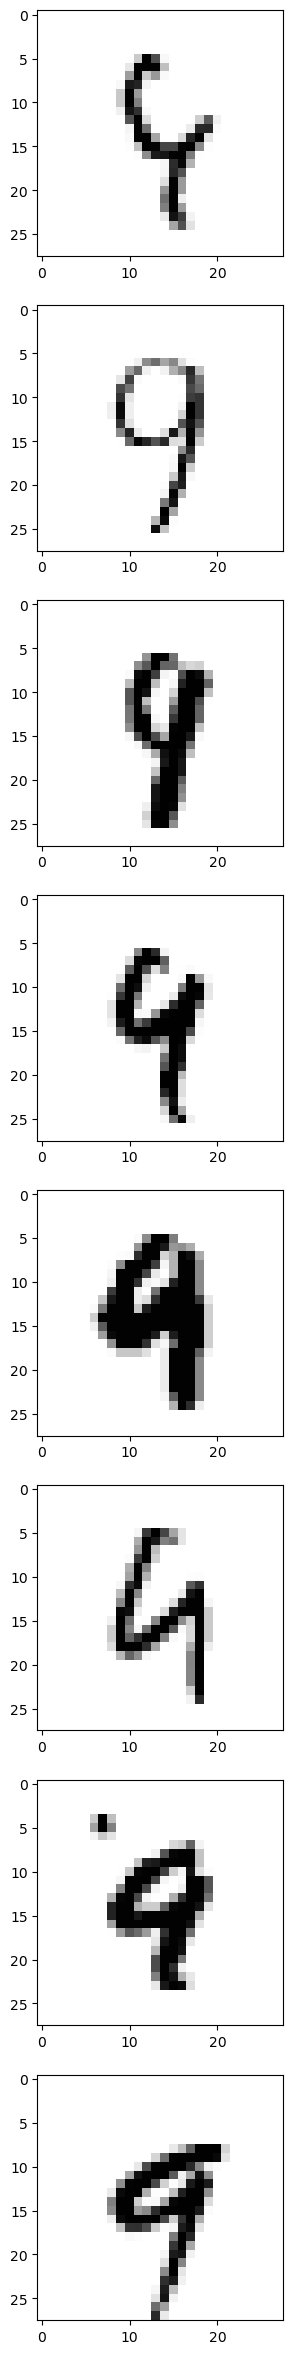

In [40]:
idx = np.where((y_pred_classes == 4) & (y_true == 9))[0]
fig = plt.figure(figsize=(5,30))
for i in range(len(idx)):
    ax = fig.add_subplot(len(idx),1 , i + 1)
    imgplot = ax.imshow(np.reshape(x_test[idx[i],:], (28,28)), cmap=mpl.colormaps['Greys'])
    imgplot.set_interpolation("nearest")
plt.show()